In [3]:
import nltk
from nltk.corpus import brown

In [4]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/alindumitru/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/alindumitru/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [5]:
corpus = brown.tagged_sents(tagset='universal')

In [6]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [7]:
len(corpus)

57340

In [8]:
inputs = []
targets = []

for sentence_tag_pairs in corpus:
    tokens = []
    target = []
    for token, tag in sentence_tag_pairs:
        tokens.append(token)
        target.append(tag)
    inputs.append(tokens)
    targets.append(target)

In [10]:
import numpy
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [11]:
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    inputs,
    targets,
    test_size=0.3
)

In [12]:
# Convert sentence to seq
MAX_VOCAB_SIZE = None

should_lowercase = False
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token='UNK' # otherwise unknown tokens will be removed and len(input) != len(target)
)

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [13]:
word2idx = word_tokenizer.word_index
V = len(word2idx)
print(f'Found {V} unique tokens.')

Found 47304 unique tokens.


In [14]:
def flatten(list_of_lists):
    flattened = [val for sublist in list_of_lists for val in sublist]
    return flattened

In [15]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [16]:
all_test_targets = set(flatten(test_targets))
all_test_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [17]:
all_train_targets == all_test_targets

True

In [18]:
# Convert targets to sequences (ints)
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [19]:
# Find max doc length before padding
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_train, maxlen_test))

In [20]:
# Padding
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print(f'Shape of data train tensor: {train_inputs_int.shape}')

Shape of data train tensor: (40138, 180)


In [21]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print(f'Shape of data test tensor: {test_inputs_int.shape}')

Shape of data test tensor: (17202, 180)


In [22]:
train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print(f'Shape of train targets tensor: {train_targets_int.shape}')

Shape of train targets tensor: (40138, 180)


In [23]:
test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print(f'Shape of test targets tensor: {test_targets_int.shape}')

Shape of test targets tensor: (17202, 180)


In [24]:
K = len(tag_tokenizer.word_index) + 1
K

13

In [25]:
D = 32
i = Input(shape=(T,))
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [26]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [28]:
r = model.fit(
    train_inputs_int,
    train_targets_int,
    epochs=5,
    validation_data=(test_inputs_int, test_targets_int)
)

Epoch 1/5


2024-04-21 14:51:06.093464: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-21 14:51:07.144303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-04-21 14:51:08.219886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


1255/1255 [==============================] - 67s 51ms/step - loss: 0.4630 - accuracy: 0.8601 - val_loss: 0.1096 - val_accuracy: 0.9655
Epoch 2/5
1255/1255 [==============================] - 65s 52ms/step - loss: 0.0707 - accuracy: 0.9781 - val_loss: 0.0859 - val_accuracy: 0.9722
Epoch 3/5
1255/1255 [==============================] - 65s 52ms/step - loss: 0.0438 - accuracy: 0.9863 - val_loss: 0.0845 - val_accuracy: 0.9732
Epoch 4/5
1255/1255 [==============================] - 67s 54ms/step - loss: 0.0329 - accuracy: 0.9896 - val_loss: 0.0863 - val_accuracy: 0.9733
Epoch 5/5
1255/1255 [==============================] - 68s 54ms/step - loss: 0.0257 - accuracy: 0.9920 - val_loss: 0.0943 - val_accuracy: 0.9714


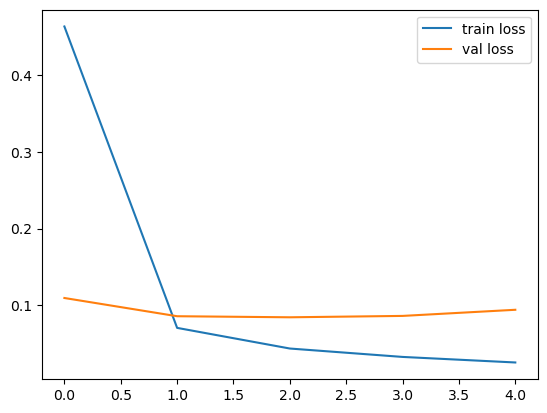

In [29]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

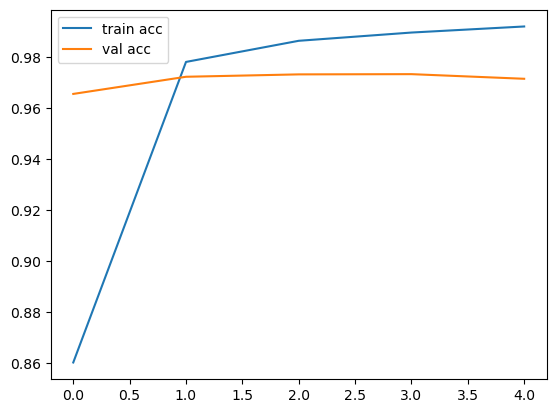

In [30]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()

In [32]:
# True model acc - aboce includes padding
train_lengths = []
for sentence in train_inputs:
    train_lengths.append(len(sentence))
    
test_lengths = []
for sentence in test_inputs:
    test_lengths.append(len(sentence))

In [34]:
import numpy as np

In [35]:
train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
    # probs is T x K
    probs_ = probs[-length:]
    preds = np.argmax(probs_, axis=1)
    train_predictions.append(preds)
    
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

1255/1255 [==============================] - 12s 9ms/step


In [36]:
test_probs = model.predict(test_inputs_int) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
    # probs is T x K
    probs_ = probs[-length:]
    preds = np.argmax(probs_, axis=1)
    test_predictions.append(preds)
    
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)

538/538 [==============================] - 5s 9ms/step


In [37]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

Train acc: 0.9939950255087857
Test acc: 0.9714462731233463


In [40]:
print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train f1: 0.9844912458627064
Test f1: 0.9075067059930279
